# Get and explore dataset

In [45]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [46]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [47]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [48]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [49]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [50]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

In [51]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# - Calculate the number of words in the dataset
# - Perform any other dataset investigation that you feel would be valuable
 

In [52]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [53]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
from keras.preprocessing.sequence import pad_sequences
padded_tokenized_data = pad_sequences(tokenized_data, maxlen=25)

In [54]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(padded_tokenized_data, labels, test_size=0.2)

In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):
    y_class_test = to_class(y_test)
    y_pred = to_class(model.predict(X_test))
    precision = precision_score(y_class_test, y_pred)
    recall = recall_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred)
    print("------------")
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F1 Score : ", f1)
    print("Confusion Matrix : ", confusion_matrix(y_class_test, y_pred))
    return precision, recall, f1 

# Build and tune model

Define network architecture

In [56]:
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, BatchNormalization, LSTM, Dense

def build_model(od, b, no_epochs):
    embedding_layer = Embedding(vocab_size, od, input_length=25)
    dropout_layer = SpatialDropout1D(0.2)
    norm_layer = BatchNormalization()
    lstm_layer = LSTM(32)
    output_layer = Dense(2, activation='softmax')
    
    model = Sequential()
    model.add(embedding_layer)
    model.add(dropout_layer)
    model.add(norm_layer)
    model.add(lstm_layer)
    model.add(output_layer)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, batch_size=b, epochs=no_epochs)
    
    return model, history, assess_model(model, X_test, y_test)

Train model

In [ ]:
# Compile model and train

output_dim_candidates = [10, 25, 50, 100]
batch_size_candidates = [20, 40, 60]

best_f1 = 0
best_model = None
best_history = None
best_stats = None
best_hyperparams = None
for od in output_dim_candidates:
    for batch_size in batch_size_candidates:
        for epochs in range(50, 52):
            model, history, (precision, recall, f1) = build_model(od, batch_size, epochs)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_history = history
                best_stats = (precision, recall, f1)
                best_hyperparams = (od, batch_size, epochs)
best_outputdim, best_batch_size, best_epochs = best_hyperparams
best_precision, best_recall, best_f1 = best_stats

Epoch 1/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6885 - accuracy: 0.5425
Epoch 2/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6624 - accuracy: 0.6011
Epoch 3/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6565 - accuracy: 0.5921
Epoch 4/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6476 - accuracy: 0.6192
Epoch 5/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6439 - accuracy: 0.6283
Epoch 6/50
72/72 [==============================] - 1s 13ms/step - loss: 0.6390 - accuracy: 0.6241
Epoch 7/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6403 - accuracy: 0.6158
Epoch 8/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6290 - accuracy: 0.6290
Epoch 9/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6347 - accuracy: 0.6220
Epoch 10/50
72/72 [==============================] - 1s 14ms/step - loss: 0.6347 - accuracy: 0.6241
Epoch 11/

72/72 [==============================] - 1s 14ms/step - loss: 0.5952 - accuracy: 0.6590
Epoch 32/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5960 - accuracy: 0.6541
Epoch 33/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5976 - accuracy: 0.6492
Epoch 34/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5899 - accuracy: 0.6625
Epoch 35/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5904 - accuracy: 0.6548
Epoch 36/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5873 - accuracy: 0.6618
Epoch 37/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5888 - accuracy: 0.6576
Epoch 38/51
72/72 [==============================] - 1s 14ms/step - loss: 0.5834 - accuracy: 0.6695
Epoch 39/51
33/72 [============>.................] - ETA: 0s - loss: 0.5848 - accuracy: 0.6606

Examine performance of model

In [59]:
print("Best Hyperparameters:")
print("output_dim: ", best_outputdim)
print("batch_size: ", best_batch_size)
print("# epochs: ", best_epochs)
print("Best stats: ")
print("precision: ", best_precision)
print("recall: ", best_recall)
print("f1 score: ", best_f1)

Best Hyperparameters:
output_dim:  50
batch_size:  20
# epochs:  6
Best stats: 
precision:  0.5582191780821918
recall:  0.8907103825136612
f1 score:  0.6863157894736842


Plot graphs for accuracy and loss

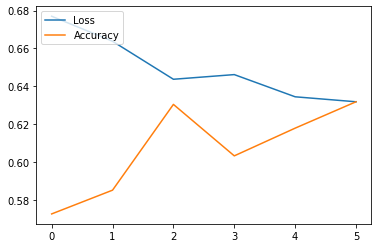

In [60]:
plt.figure()
plt.plot(best_history.history['loss'], label='Loss')
plt.plot(best_history.history['accuracy'], label='Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.close()

# Make a prediction

In [61]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=25)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
y_pred = to_word_label(best_model.predict(padded))
for i in range(len(y_pred)):
    print(prediction_data[i], " : ", y_pred[i])

this book is fabulous  :  negative
i hated this book  :  negative
the best  :  negative
no good  :  negative
okay  :  negative
